## Setup environment

In [ ]:
! pip install monai
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandAffined
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np

#print_config()

## Set MSD Spleen dataset path

In [27]:
files = glob.glob(os.path.join(data_dir, "imagesTr", "*"))
nii_files = sorted([f for f in files if f.endswith(".nii.gz")])
print(nii_files)

[]


In [32]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [33]:
len(train_images), len(train_labels), len(train_files), len(val_files)

(41, 41, 32, 9)

## Set deterministic training for reproducibility

In [34]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [70]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], reader="NibabelReader"),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], reader="NibabelReader"),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


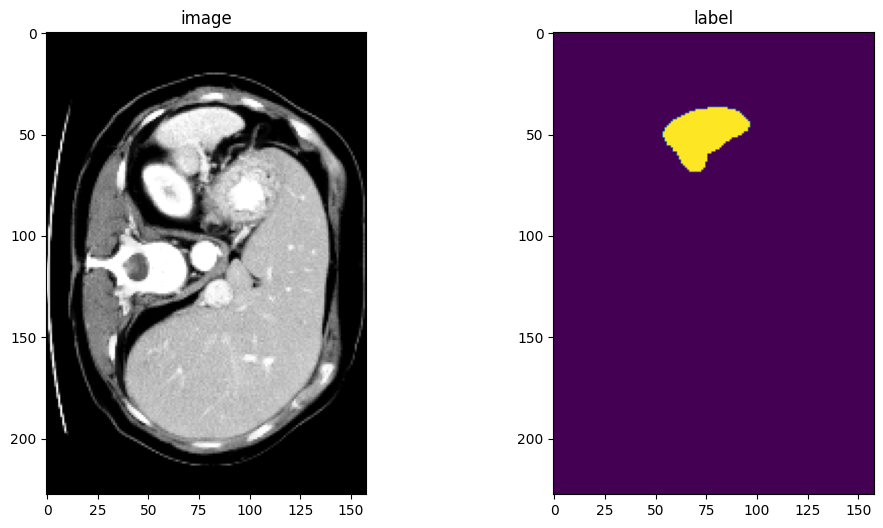

In [36]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [74]:
# train_ds = Dataset(data=train_files, transform=train_transforms)
# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_ds = CacheDataset(data=3 * train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# val_ds = Dataset(data=val_files, transform=val_transforms)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


## Create Model, Loss, Optimizer

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda")
print(f"Using device: {device}")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# Wrap model for DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = torch.nn.DataParallel(model)

# Define loss, optimizer, and metric
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Using device: cuda
Using 2 GPUs with DataParallel


## Execute a typical PyTorch training process

In [ ]:
max_epochs = 150
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Initialize TensorBoard writer
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    #print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    # Log the loss value to TensorBoard
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "./best_metric_model.}")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

writer.flush()
writer.close()


----------
epoch 1 average loss: 0.6117
----------
epoch 2 average loss: 0.5709
dice_metric 0.0693165585398674
saved new best metric model
current epoch: 2 current mean dice: 0.0693
best mean dice: 0.0693 at epoch: 2
----------
epoch 3 average loss: 0.5568
----------
epoch 4 average loss: 0.5283
dice_metric 0.051593661308288574
current epoch: 4 current mean dice: 0.0516
best mean dice: 0.0693 at epoch: 2
----------
epoch 5 average loss: 0.5033
----------
epoch 6 average loss: 0.4874
dice_metric 0.10327785462141037
saved new best metric model
current epoch: 6 current mean dice: 0.1033
best mean dice: 0.1033 at epoch: 6
----------
epoch 7 average loss: 0.4680
----------
epoch 8 average loss: 0.4447
dice_metric 0.09233119338750839
current epoch: 8 current mean dice: 0.0923
best mean dice: 0.1033 at epoch: 6
----------
epoch 9 average loss: 0.4205
----------
epoch 10 average loss: 0.4089
dice_metric 0.25502732396125793
saved new best metric model
current epoch: 10 current mean dice: 0.2550

In [77]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9442 at epoch: 98


## Plot the loss and metric

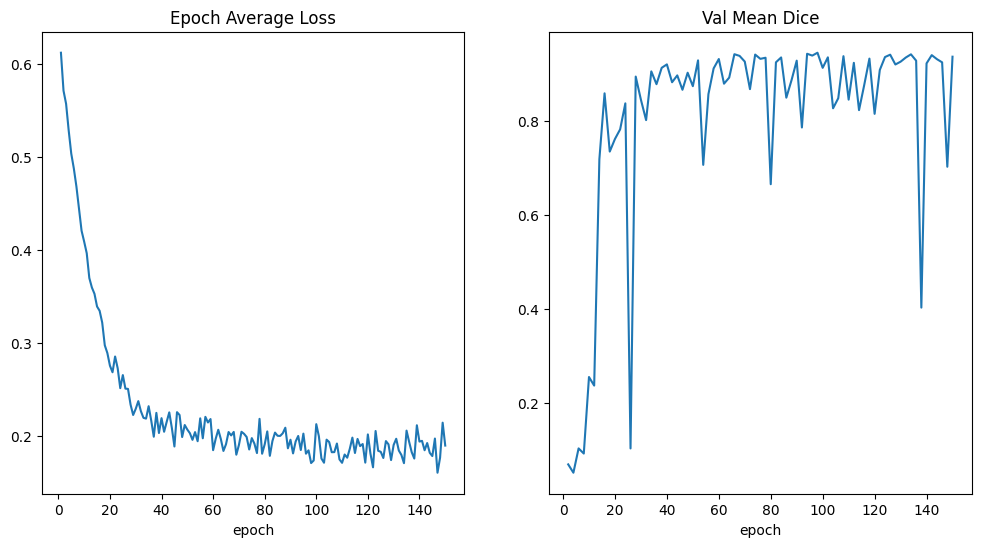

In [78]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [79]:
result_path = "/kaggle/working/"

In [ ]:
model.load_state_dict(torch.load(os.path.join(result_path, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 2]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 90], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 90])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 90])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [81]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [82]:
model.load_state_dict(torch.load(os.path.join(result_path, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.3729214370250702


## Inference on Test Set

In [83]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii")))

test_data = [{"image": image} for image in test_images]

test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [84]:
# uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(os.path.join(result_path, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

        # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)
        
        original_image = loader(test_output[0].meta["filename_or_obj"])
        
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()